# Linear Deconvolution with PSF estimated from FRC 
In [here](http://localhost:8888/notebooks/notebooks/2018-06-05%20Deconvolution%20and%20FRC%20with%20a%20Single%20Split%20Image%20(very%20noisy).ipynb) I tried to deconvolve a very low SNR confocal image, using a theoretical confocal PSF. From the results it was evident that the PSF was not correct, as the deconvolution did not corverge properly -- and resulted into strong amplifiction of noise. Here I try to mitigate the problem, by estimating the PSF directly from the FRC measurement of the image resolution.

In [1]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.messages import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots
from supertomo.processing.deconvolution import wiener



## Setup deconvolution

Same way as previously, I set the deconvolution to stop after 60 iterations. The regular confocal image is used as the first quess. A constant image can be used as well, and it will yield the same result -- but the FRC measures are a bit more pleasant in the beginning of the deconvolution process when using the image.

In [2]:
from supertomo.ui import deconvolution_options as options
n_iterations = 60
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=snr" 
             " --resolution-snr-value=0.25").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. There is a zero offset in the image, which I correct here, to make the devonvolution behave nicely. 

In [3]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)
image_copy = Image(image.copy(), image.spacing)



The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20


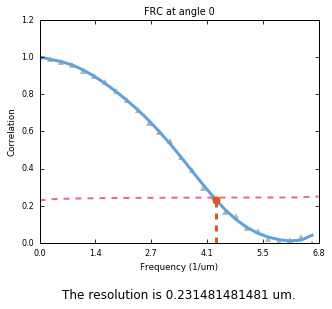

In [4]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

## Generate PSF

Based on the FRC measurement, a PSF is genrated with a simple Gaussian model, using the FRC resolution figure as the FWHM value.  

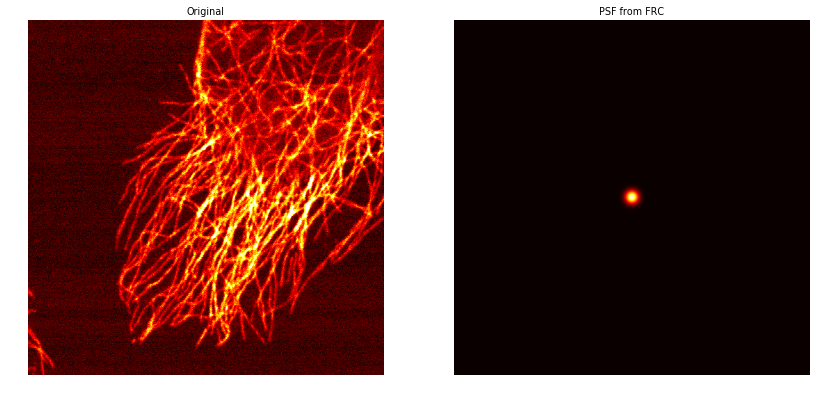

In [9]:
import supertomo.psf.psfgen as psfgen

fwhm = [results[0].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         psf,
                         image1_title="Original",
                         image2_title="PSF from FRC"
                         
                    )

In [14]:
from supertomo.data.io.write import image as imwrite

directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_FRC_Deconvolution"

imwrite(os.path.join(directory, "psf.tif"), Image((psf*255).astype(np.uint8), psf.spacing))

## Run deconvolution

Having generated the PSF, deconvolution is now run for 60 iterations. No stopping condition is used, because I wanted to evaluate the performance of the various parameters later on. For later FRC analysis, the intermediate results are saved on the disk.

In [6]:
from scipy.ndimage import gaussian_filter

#psf = Image(gaussian_filter(psf), psf.spacing)


result = wiener.wiener_deconvolution(image, psf, snr=10)

The zoom is  (0.6033977866125201, 0.6033977866125201)


/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


## Results

It is evident that 60 iterations are excessive, although the result is much improved from the one seen with the theoretical PSF. The algorithm clearly is able to focuse more on the details, rather than strongly amplifying the noise and trying to make the details smaller than they are.

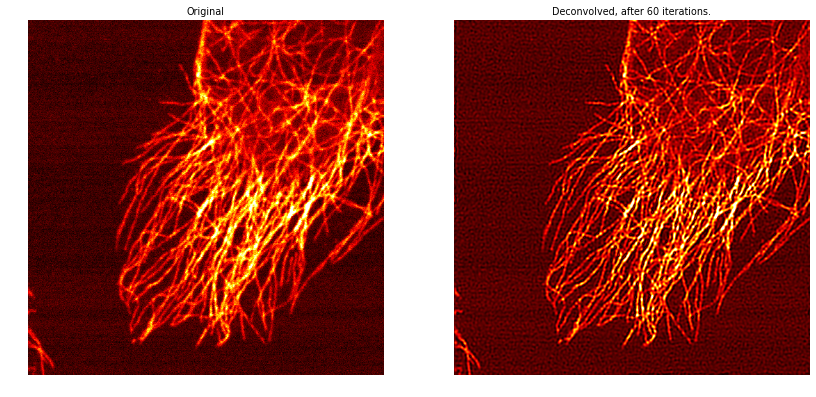

In [7]:

showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(n_iterations))


